<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/stock_test_with_differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf


# 1. Preprocessing

In [3]:
def differencing(df, difference_columns, shift=1):

  for column in difference_columns:
    df[column] = (df[column] - df[column].shift(shift))/df[column].shift(shift)
  
  return df.dropna()


def make_multistep_dataset(df, features_column, steps=1):
  
  for i in range(steps):
    for feature in features_column:
      df[feature+"(t-"+str(i+1)+")"] = df[feature+"(t)"].shift(i+1)
  
  df = df.dropna()
  return df


def get_file_index(file_name):

    index = file_name.split(".")[0]
    start = 0
    while (start < len(index) and index[start] == "0"):
      start += 1
    return int(index[start:])


def load_data(data_folder, n_stocks, columns, steps):

  files = os.listdir(data_folder)
  files.sort(key = lambda x: get_file_index(x))

  df = None
  for i in range(n_stocks):
    
    # get file name
    file = files[i]

    # load data
    df_temp = pd.read_csv(data_folder+"/"+file, names=columns)

    # add percentage return (close(t) - close(t-1))/close(t)
    df_temp['percentage_return(t)'] = (df_temp['close(t)'] - df_temp['close(t)'].shift(1))/df_temp['close(t)']

    # differencing 
    df_temp = differencing(df_temp, columns)

    # make multistep dataset
    features_column = [x[:-3] for x in columns]
    df_temp = make_multistep_dataset(df_temp, features_column, steps)
    df_temp = df_temp.dropna()
    df_temp['time_index'] = df_temp.index #keep the original timestep index of each record
    df_temp['ticker'] = file.split('.')[0] #get the ticker number

    # concatenate with df
    if (i==0):
      df = df_temp
    else:
      df = pd.concat([df, df_temp])

    # make sure the index is correct
    df = df.reset_index(drop = True)
  
  return df


class min_max_scaler: # scale for each ticker

  def __init__(self):

    self.scaler = None
  
  def fit(self, df, fit_columns):
    
    if ('ticker' not in df.columns):
      raise ValueError("df does not have the column 'ticker.'")
    
    # clear self.scaler
    self.scaler = pd.DataFrame(columns=["ticker", "min", "max"])
    
    tickers = list(set(list(df['ticker'])))
    tickers.sort(key = lambda x: get_file_index(x))
    self.scaler.ticker = tickers
    self.scaler = self.scaler.set_index('ticker', drop=True)

    for ticker in tickers:
      # choose the ticker then choose the columns
      df_ticker = df.loc[df.ticker == ticker][fit_columns] 
      # get the min and the max for the ticker
      self.scaler.at[ticker, 'min_val'] = df_ticker.values.min()
      self.scaler.at[ticker, 'max_val'] = df_ticker.values.max()
  
  def transform(self, df, transform_columns):

    if (self.scaler is None):
      raise ValueError("The scaler has not been fitted.")
    if ('ticker' not in df.columns):
      raise ValueError("df does not have the column 'ticker.'")

    # generate a scale for the current df
    min_map = dict(zip(list(self.scaler.index), list(self.scaler.min_val)))
    max_map = dict(zip(list(self.scaler.index), list(self.scaler.max_val)))
    min_scale = df['ticker'].map(min_map)
    max_scale = df['ticker'].map(max_map)

    # transform each column
    for column in transform_columns:
      df[column] = (df[column].values - min_scale)/(max_scale - min_scale)
    
    return df
  
  def fit_transform(self, df, fit_columns, transform_columns):

    self.fit(df, fit_columns)
    return self.transform(df, transform_columns)
  
  def inverse_transform(self, df, transform_columns):

    if (self.scaler is None):
      raise ValueError("The scaler has not been fitted.")
    if ('ticker' not in df.columns):
      raise ValueError("df does not have the column 'ticker.'")
    
    # generate a scale for the current df
    min_map = dict(zip(list(self.scaler.index), list(self.scaler.min_val)))
    max_map = dict(zip(list(self.scaler.index), list(self.scaler.max_val)))
    min_scale = df['ticker'].map(min_map)
    max_scale = df['ticker'].map(max_map)

    # inverse transform each column
    for column in transform_columns:
      df[column] = (df[column].values * (max_scale - min_scale)) + min_scale
    
    return df






def prepare_train_data(df, features_column, target_column, steps, start=0, train_window=72, delta=1):
  '''
  'features_column' here is not necessarily the same as 'features_column' in make_multistep_dataset() and is a list
  'target_column' is a string, e.g. "open"
  '''

  df = df.loc[(df.time_index >= start) & (df.time_index < start+train_window)]

  train_columns = []
  for i in range(1, steps+1):
      train_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # fit transform the data
  scaler = min_max_scaler()
  transform_columns = train_columns + [target_column+"(t)"]
  df = scaler.fit_transform(df, train_columns, transform_columns)

  X_train = df[train_columns].values
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], steps, len(features_column))) #lstm data shape: (samples, timesteps, features)
  y_train = df[target_column+"(t)"].values

  print(X_train.shape, X_train_lstm.shape, y_train.shape)
  return (X_train, X_train_lstm, y_train, scaler) #scaler is to be used on the test set


def prepare_test_data(df, features_column, target_column, steps, scaler, start=0, train_window=72, delta=1):
  '''
  'features_column' here is not necessarily the same as 'features_column' in make_multistep_dataset() and is a list
  'target_column' is a string, e.g. "open"
  '''

  df = df.loc[(df.time_index >= start) & (df.time_index < start+train_window)]

  #select the features
  train_columns = []
  for i in range(1, steps+1):
      train_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # transform the data
  transform_columns = train_columns + [target_column+"(t)"]
  df = scaler.transform(df, transform_columns)
  
  X_train = df[train_columns].values
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], steps, len(features_column))) #lstm data shape: (samples, timesteps, features)
  y_train = df[target_column+"(t)"].values
  trade_tic = df['ticker']

  print(X_train.shape, X_train_lstm.shape, y_train.shape)
  return (X_train, X_train_lstm, y_train, trade_tic)



# 2. Models

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor



def train_lstm(X_train, y_train, epochs=50, batch_size=64):

  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation="tanh"))
    model.add(Dense(1))

    model.compile(loss='mae', optimizer="adam")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)
    return model


def train_lr(X_train, y_train):
  
  lr_regressor = LinearRegression()
  model = lr_regressor.fit(X_train, y_train)

  return model


def train_lasso(X_train, y_train):

  lasso_regressor = Lasso(alpha=0.001)
  model = lasso_regressor.fit(X_train, y_train)
  return model


def train_ridge(X_train, y_train):

  ridge_regressor = Ridge(alpha=0.0001)
  model = ridge_regressor.fit(X_train, y_train)

  return model


def train_svm(X_train, y_train):
  with tf.device('/device:GPU:0'):
    svr = SVR(C=1.0, kernel='rbf', gamma=0.1)
    model = svr.fit(X_train, y_train)
    return model


def train_gbm(X_train, y_train):
  with tf.device('/device:GPU:0'):
    gbr = GradientBoostingRegressor(loss='lad', learning_rate=0.1, n_estimators=50, max_depth=5)
    model = gbr.fit(X_train, y_train)
    return model


def train_ada(X_train, y_train):
  with tf.device('/device:GPU:0'):
    base_estimator = DecisionTreeRegressor(max_depth=5)
    ada = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=50, learning_rate=0.01, loss='linear')
    model = ada.fit(X_train, y_train)
    return model


#model evaluation
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import mean_squared_log_error

    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score
    y_predict = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_predict)
    

    mse = mean_squared_error(y_test, y_predict)
    #msle = mean_squared_log_error(y_test, y_predict)

    explained_variance = explained_variance_score(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)

    return mae

# 3. Training (Multiple Stocks Rolling Window)

In [5]:
# prepare data
columns = ["open(t)", "close(t)", "high(t)", "low(t)"]
steps = 20 # include 20 timestamps for each sample
data_folder = "/content/drive/MyDrive/StockML /processed_data"
n_stocks = 500 # use 500 stocks
df = load_data(data_folder, n_stocks, columns, steps)
display(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,open(t),close(t),high(t),low(t),percentage_return(t),open(t-1),close(t-1),high(t-1),low(t-1),open(t-2),close(t-2),high(t-2),low(t-2),open(t-3),close(t-3),high(t-3),low(t-3),open(t-4),close(t-4),high(t-4),low(t-4),open(t-5),close(t-5),high(t-5),low(t-5),open(t-6),close(t-6),high(t-6),low(t-6),open(t-7),close(t-7),high(t-7),low(t-7),open(t-8),close(t-8),high(t-8),low(t-8),open(t-9),close(t-9),high(t-9),...,high(t-11),low(t-11),open(t-12),close(t-12),high(t-12),low(t-12),open(t-13),close(t-13),high(t-13),low(t-13),open(t-14),close(t-14),high(t-14),low(t-14),open(t-15),close(t-15),high(t-15),low(t-15),open(t-16),close(t-16),high(t-16),low(t-16),open(t-17),close(t-17),high(t-17),low(t-17),open(t-18),close(t-18),high(t-18),low(t-18),open(t-19),close(t-19),high(t-19),low(t-19),open(t-20),close(t-20),high(t-20),low(t-20),time_index,ticker
0,0.003744,0.009398,0.021850,0.003808,0.009311,-0.002800,0.003300,-0.012850,-0.001426,-0.035987,-0.032391,-0.026363,-0.021850,0.005882,-0.003183,0.012212,0.005610,-0.004953,0.010570,-0.017333,-0.012009,-0.059297,-0.020261,-0.047014,-0.019919,-0.006731,-0.061285,-0.016250,-0.055579,-0.001680,-0.018664,-0.014778,0.003863,-0.024580,0.020313,-0.016552,0.004310,-0.007724,-0.031160,0.004868,...,-0.015930,-0.007060,0.017507,0.013519,0.002796,0.009644,0.029614,-0.014136,0.002402,0.028017,0.004310,0.071861,0.044751,0.020678,0.016652,-0.051724,-0.035887,0.009325,0.008396,0.063291,0.061644,-0.000444,0.001327,0.012373,0.015652,0.011675,0.020777,-0.011790,-0.012452,0.005872,0.000452,0.031532,0.006482,0.000452,0.026914,-0.004931,0.032114,0.040922,21,000001
1,-0.001865,0.062849,0.041856,0.009483,0.059133,0.003744,0.009398,0.021850,0.003808,-0.002800,0.003300,-0.012850,-0.001426,-0.035987,-0.032391,-0.026363,-0.021850,0.005882,-0.003183,0.012212,0.005610,-0.004953,0.010570,-0.017333,-0.012009,-0.059297,-0.020261,-0.047014,-0.019919,-0.006731,-0.061285,-0.016250,-0.055579,-0.001680,-0.018664,-0.014778,0.003863,-0.024580,0.020313,-0.016552,...,-0.002428,0.002928,0.012290,-0.005255,-0.015930,-0.007060,0.017507,0.013519,0.002796,0.009644,0.029614,-0.014136,0.002402,0.028017,0.004310,0.071861,0.044751,0.020678,0.016652,-0.051724,-0.035887,0.009325,0.008396,0.063291,0.061644,-0.000444,0.001327,0.012373,0.015652,0.011675,0.020777,-0.011790,-0.012452,0.005872,0.000452,0.031532,0.006482,0.000452,22,000001
2,0.055114,-0.003942,0.017904,0.055425,-0.003958,-0.001865,0.062849,0.041856,0.009483,0.003744,0.009398,0.021850,0.003808,-0.002800,0.003300,-0.012850,-0.001426,-0.035987,-0.032391,-0.026363,-0.021850,0.005882,-0.003183,0.012212,0.005610,-0.004953,0.010570,-0.017333,-0.012009,-0.059297,-0.020261,-0.047014,-0.019919,-0.006731,-0.061285,-0.016250,-0.055579,-0.001680,-0.018664,-0.014778,...,0.004868,-0.032527,-0.004452,-0.008939,-0.002428,0.002928,0.012290,-0.005255,-0.015930,-0.007060,0.017507,0.013519,0.002796,0.009644,0.029614,-0.014136,0.002402,0.028017,0.004310,0.071861,0.044751,0.020678,0.016652,-0.051724,-0.035887,0.009325,0.008396,0.063291,0.061644,-0.000444,0.001327,0.012373,0.015652,0.011675,0.020777,-0.011790,-0.012452,0.005872,23,000001
3,-0.003099,-0.025066,-0.021879,-0.034713,-0.025710,0.055114,-0.003942,0.017904,0.055425,-0.001865,0.062849,0.041856,0.009483,0.003744,0.009398,0.021850,0.003808,-0.002800,0.003300,-0.012850,-0.001426,-0.035987,-0.032391,-0.026363,-0.021850,0.005882,-0.003183,0.012212,0.005610,-0.004953,0.010570,-0.017333,-0.012009,-0.059297,-0.020261,-0.047014,-0.019919,-0.006731,-0.061285,-0.016250,...,-0.016552,0.004310,-0.007724,-0.031160,0.004868,-0.032527,-0.004452,-0.008939,-0.002428,0.002928,0.012290,-0.005255,-0.015930,-0.007060,0.017507,0.013519,0.002796,0.009644,0.029614,-0.014136,0.002402,0.028017,0.004310,0.071861,0.044751,0.020678,0.016652,-0.051724,-0.035887,0.009325,0.008396,0.063291,0.061644,-0.000444,0.001327,0.012373,0.015652,0.011675,24,000001
4,-0.011545,-0.033378,-0.012719,-0.017520,-0.034531,-0.003099,-0.025066,-0.021879,-0.034713,0.055114,-0.003942,0.017904,0.055425,-0.00186

In [ ]:
# training set up 
features_column = ["open", "close", "high", "low"] 
target_column = "close"
steps = 20 #use 20 timesteps for each training sample
n_windows = 40 #20 (train, test, trade) triples in total
train_start = steps + 1
train_starts = list(range(train_start, train_start+n_windows))
train_window = 48
test_starts = list(range(train_start+train_window, train_start+train_window+n_windows))
test_window = 12
trade_starts = list(range(train_start+train_window+test_window, train_start+train_window+test_window+n_windows))
trade_window = 1
lstm_epochs = 40 

unique_ticker = list(set(list(df['ticker'])))
unique_ticker.sort(key = lambda x: get_file_index(x))
unique_datetime = trade_starts
df_predict_lr = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lasso = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ridge = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_svm= pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_gbm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ada = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lstm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)

df_predict_best = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_best_model_name = pd.DataFrame(columns=['model_name'], index=unique_datetime)
df_actual = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
evaluation_record = []
scalers = {}


for i in range(n_windows):

  # get start dates
  train_start = train_starts[i]
  test_start = test_starts[i]
  trade_start = trade_starts[i]

  # prepare datasets
  X_train, X_train_lstm, y_train, scaler = prepare_train_data(df, features_column, target_column, steps, train_start, train_window)
  X_test, X_test_lstm, y_test, _ = prepare_test_data(df, features_column, target_column, steps, scaler, test_start, test_window)
  X_trade, X_trade_lstm, y_trade, trade_tic = prepare_test_data(df, features_column, target_column, steps, scaler, trade_start, trade_window)
  scalers[trade_start] = scaler

  # train 
  lr_model = train_lr(X_train, y_train)
  lasso_model = train_lasso(X_train, y_train)
  ridge_model = train_ridge(X_train, y_train)
  svm_model = train_svm(X_train, y_train)
  gbm_model = train_gbm(X_train, y_train)
  ada_model = train_ada(X_train, y_train)
  lstm_model = train_lstm(X_train_lstm, y_train, lstm_epochs)

  # validate
  lr_eval = evaluate_model(lr_model, X_test, y_test)
  lasso_eval = evaluate_model(lasso_model, X_test, y_test)
  ridge_eval = evaluate_model(ridge_model, X_test, y_test)
  svm_eval = evaluate_model(svm_model, X_test, y_test)
  gbm_eval = evaluate_model(gbm_model, X_test, y_test)
  ada_eval = evaluate_model(ada_model, X_test, y_test)
  lstm_eval = evaluate_model(lstm_model, X_test_lstm, y_test)

  # trade
  y_trade_lr = lr_model.predict(X_trade)
  y_trade_lasso = lasso_model.predict(X_trade)
  y_trade_ridge = ridge_model.predict(X_trade)
  y_trade_svm = svm_model.predict(X_trade)
  y_trade_gbm = gbm_model.predict(X_trade)
  y_trade_ada = ada_model.predict(X_trade)
  y_trade_lstm = lstm_model.predict(X_trade_lstm).flatten()

  eval_data = [[lr_eval, y_trade_lr], 
                    [lasso_eval, y_trade_lasso],
                    [ridge_eval, y_trade_ridge],
                    [svm_eval,y_trade_svm],
                    [gbm_eval,y_trade_gbm],                     
                    [ada_eval,y_trade_ada],
                    [lstm_eval,y_trade_lstm]
                    ]

  eval_table = pd.DataFrame(eval_data, columns=['model_eval', 'model_predict_close'],
                                  index=['lr', 'lasso','ridge', 'svm', 'gbm', 'ada', 'lstm'])   
  evaluation_record.append((trade_start, eval_table))

  # lowest error score model
  y_trade_best = eval_table.model_predict_close.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  best_model_name = eval_table.index.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  df_best_model_name.loc[trade_start] = best_model_name

  # prepare predicted close price table
  assert list(trade_tic)==unique_ticker # ensure that the row is filled in correctly
  df_predict_lr.loc[trade_start] = y_trade_lr
  df_predict_lasso.loc[trade_start] = y_trade_lasso
  df_predict_ridge.loc[trade_start] = y_trade_ridge
  df_predict_svm.loc[trade_start] = y_trade_svm
  df_predict_gbm.loc[trade_start] = y_trade_gbm
  df_predict_ada.loc[trade_start] = y_trade_ada
  df_predict_lstm.loc[trade_start] = y_trade_lstm
  df_predict_best.loc[trade_start] = y_trade_best
  print(y_trade_lr)
  print(y_trade_lstm)

  # fill in the actual close price
  df_actual.loc[trade_start] = y_trade

  print("Trade date:", trade_start)


# save the raw results
df_predict_lr.to_csv("/content/drive/MyDrive/StockML /lr_d.csv")
df_predict_lasso.to_csv("/content/drive/MyDrive/StockML /lasso_d.csv")
df_predict_ridge.to_csv("/content/drive/MyDrive/StockML /ridge_d.csv")
df_predict_svm.to_csv("/content/drive/MyDrive/StockML /svm_d.csv")
df_predict_gbm.to_csv("/content/drive/MyDrive/StockML /gbm_d.csv")
df_predict_ada.to_csv("/content/drive/MyDrive/StockML /ada_d.csv")
df_predict_lstm.to_csv("/content/drive/MyDrive/StockML /lstm_d.csv")
df_predict_best.to_csv("/content/drive/MyDrive/StockML /best_d.csv")
df_actual.to_csv("/content/drive/MyDrive/StockML /actual_d.csv")
df_best_model_name.to_csv("/content/drive/MyDrive/StockML /best_model_name_d.csv")

# Show Accuracy

In [8]:
# get the saved raw results
df_predict_lr = pd.read_csv("/content/drive/MyDrive/StockML /lr_d.csv", index_col=0)
df_predict_lasso = pd.read_csv("/content/drive/MyDrive/StockML /lasso_d.csv", index_col=0)
df_predict_ridge = pd.read_csv("/content/drive/MyDrive/StockML /ridge_d.csv", index_col=0)
df_predict_svm = pd.read_csv("/content/drive/MyDrive/StockML /svm_d.csv", index_col=0)
df_predict_gbm = pd.read_csv("/content/drive/MyDrive/StockML /gbm_d.csv", index_col=0)
df_predict_ada = pd.read_csv("/content/drive/MyDrive/StockML /ada_d.csv", index_col=0)
df_predict_lstm = pd.read_csv("/content/drive/MyDrive/StockML /lstm_d.csv", index_col=0)
df_predict_best = pd.read_csv("/content/drive/MyDrive/StockML /best_d.csv", index_col=0)
df_actual = pd.read_csv("/content/drive/MyDrive/StockML /actual_d.csv", index_col=0)

# inverse scaling
for trade_start in trade_starts:
  sc = scalers[trade_start]
  assert list(df_predict_lr.columns) == list(sc.scaler.index) # check that the two are aligned
  df_predict_lr.loc[trade_start] = (df_predict_lr.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_lasso.loc[trade_start] = (df_predict_lasso.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_ridge.loc[trade_start] = (df_predict_ridge.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_svm.loc[trade_start] = (df_predict_svm.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_gbm.loc[trade_start] = (df_predict_gbm.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_ada.loc[trade_start] = (df_predict_ada.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_lstm.loc[trade_start] = (df_predict_lstm.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_best.loc[trade_start] = (df_predict_best.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_actual.loc[trade_start] = (df_actual.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val

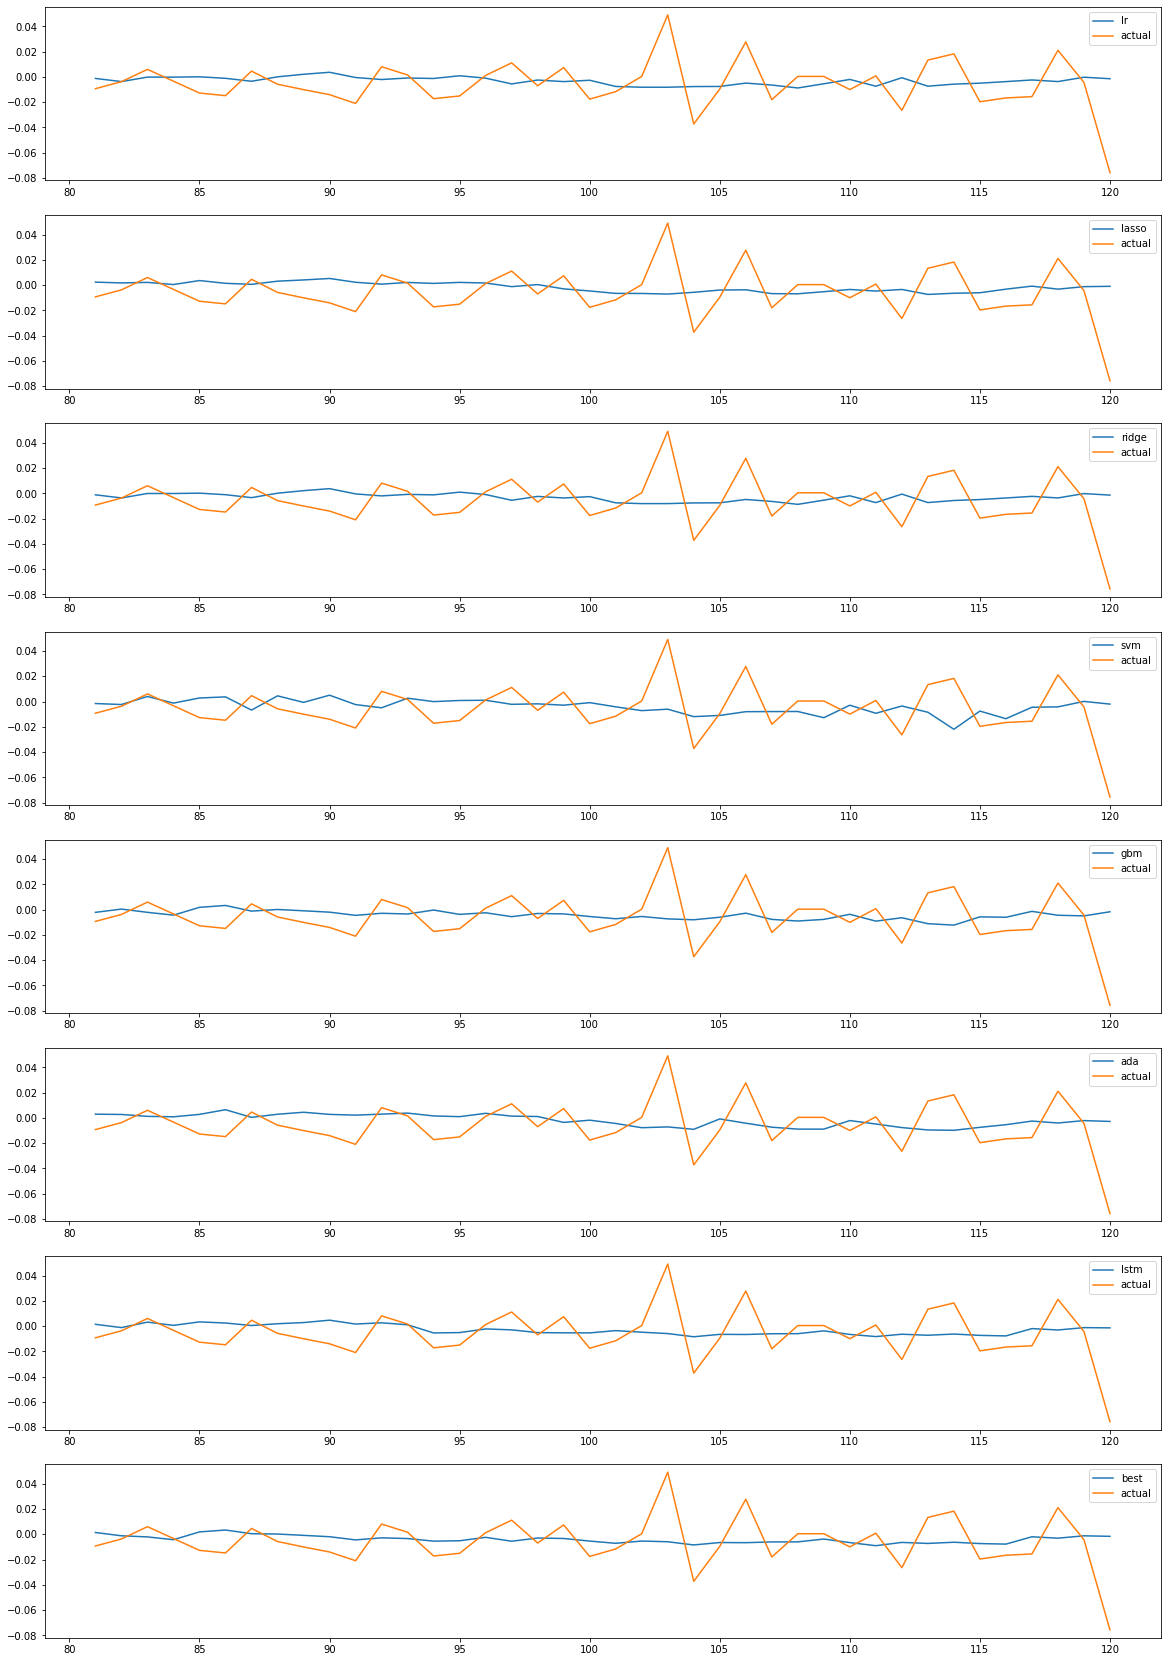

In [9]:
# plot
fig, axs = plt.subplots(8, figsize=(20,30))
ticker_index = 1 # the index of the ticker (start from 0)
x = trade_starts
axs[0].plot(x, df_predict_lr[unique_ticker[ticker_index]], label="lr")
axs[0].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[1].plot(x, df_predict_lasso[unique_ticker[ticker_index]], label="lasso")
axs[1].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[2].plot(x, df_predict_ridge[unique_ticker[ticker_index]], label="ridge")
axs[2].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[3].plot(x, df_predict_svm[unique_ticker[ticker_index]], label="svm")
axs[3].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[4].plot(x, df_predict_gbm[unique_ticker[ticker_index]], label="gbm")
axs[4].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[5].plot(x, df_predict_ada[unique_ticker[ticker_index]], label="ada")
axs[5].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[6].plot(x, df_predict_lstm[unique_ticker[ticker_index]], label="lstm")
axs[6].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[7].plot(x, df_predict_best[unique_ticker[ticker_index]], label="best")
axs[7].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
for i in range(8):
  axs[i].legend()
plt.show()

# Calculate Return
long-only strategy

In [13]:

def long_only_strategy(df_predict_return, actual_return, trade_starts, top_quantile_threshold=0.75):

  long_dict = {}
  for i in range(df_predict_return.shape[0]):
      top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
      # Select Top 25% Stocks
      long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]

  portfolio_return_dic = {}
  for i in range(1, len(trade_starts)): # start from 1 because the first row is dropped in "transform_close_to_return"
  
      # calculate weights based on predicted return
      min_return = min(long_dict[trade_starts[i]].values)
      long_normalize_weight = (long_dict[trade_starts[i]]-min_return) / sum(long_dict[trade_starts[i]].values - min_return)
      # map date and tic
      long_tic_return = actual_return[actual_return.index == trade_starts[i]][long_dict[trade_starts[i]].index]
      # return * weight
      long_return_table = long_tic_return * long_normalize_weight
      portfolio_return_dic[trade_starts[i]] = long_return_table.values.sum()

  df_portfolio_return = pd.DataFrame.from_dict(portfolio_return_dic, orient='index')
  df_portfolio_return = df_portfolio_return.reset_index()
  df_portfolio_return.columns = ['trade_start', 'return']
  df_portfolio_return.index = df_portfolio_return.trade_start
  df_portfolio_return = df_portfolio_return['return']
  return df_portfolio_return


In [14]:
# get the df for actual return (in percentage)
trade_start = trade_starts[0] # start from 0
trade_end = trade_starts[-1]
actual_return = pd.DataFrame(index=trade_starts, columns=unique_ticker)
for ticker in unique_ticker:
   actual_return[ticker] = list(df.loc[(df.time_index>=trade_start) & (df.time_index<=trade_end) & (df.ticker==ticker)]['percentage_return(t)'])
#actual_return_2 = transform_close_to_return(df_actual)

# get return
df_portfolio_return_lr = long_only_strategy(df_predict_lr, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_lasso = long_only_strategy(df_predict_lasso, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_ridge = long_only_strategy(df_predict_ridge, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_svm   = long_only_strategy(df_predict_svm,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_gbm   = long_only_strategy(df_predict_gbm,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_ada   = long_only_strategy(df_predict_ada,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_lstm  = long_only_strategy(df_predict_lstm, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_best  = long_only_strategy(df_predict_best, actual_return,trade_starts,top_quantile_threshold = 0.75)


#get equally portfolio return
selected_return = actual_return[unique_ticker]
equally_portfolio_return=[]
for i in range(0, len(trade_starts)-1):
    return_remove_nan = selected_return.iloc[i][~np.isnan(actual_return.iloc[i])]
    equally_portfolio_return.append(sum(return_remove_nan)/len(return_remove_nan))
    
df_equally_portfolio_return=pd.DataFrame(equally_portfolio_return,trade_starts[1:])
df_equally_portfolio_return=df_equally_portfolio_return.reset_index()
df_equally_portfolio_return.columns= ['trade_start','return']
df_equally_portfolio_return.index=df_equally_portfolio_return.trade_start
df_equally_portfolio_return=df_equally_portfolio_return['return']

Text(0.5, 1.0, 'Cumulative Return')

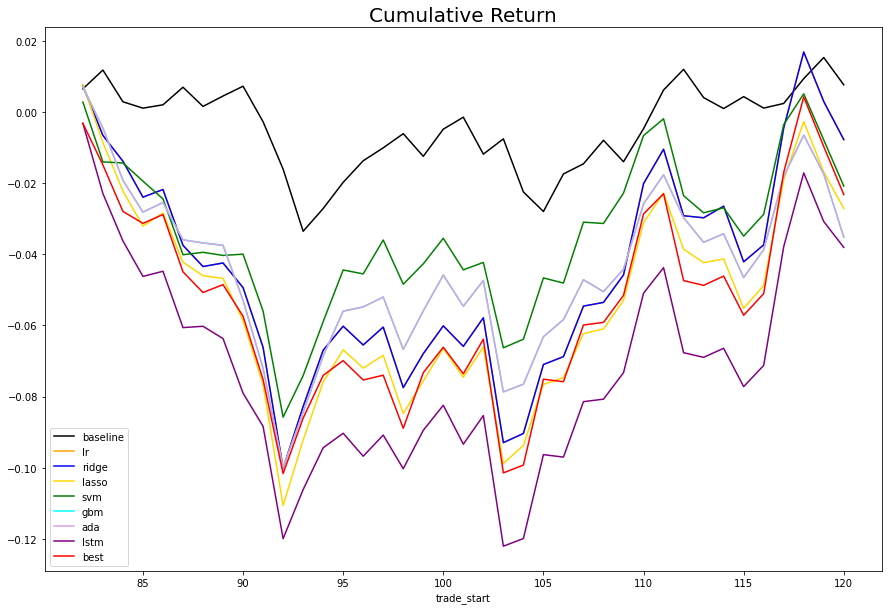

In [15]:
plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')

lr = ((df_portfolio_return_lr+1).cumprod()-1).plot(c='orange',label='lr')
ridge = ((df_portfolio_return_ridge+1).cumprod()-1).plot(c='b',label='ridge')
lasso = ((df_portfolio_return_lasso+1).cumprod()-1).plot(c='gold',label='lasso')
svm = ((df_portfolio_return_svm+1).cumprod()-1).plot(c='green',label='svm')
gbm = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='cyan',label='gbm')
ada = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='plum',label='ada')
lstm = ((df_portfolio_return_lstm+1).cumprod()-1).plot(c='purple',label='lstm')

best = ((df_portfolio_return_best+1).cumprod()-1).plot(c='r',label='best')
plt.legend()


plt.title('Cumulative Return',size=20)